## Install waymo_open_dataset package

In [1]:
import os
import math
import numpy as np
import itertools

from tqdm import tqdm

from ad_config_search.waymo_utils import *

from pathlib import Path

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [3]:
def featurize(frames_path, part_length_s):
    assert 20%part_length_s == 0, "20s (the time length of each scenario in waymo) is not divisible by {}".format(part_length_s)
    frames = frames_from_path(frames_path)
    result = []
    for i, frame_chunck in enumerate(chunks(frames, 10*part_length_s)):
        bbox_info = collect_bbox_info_per_frame(frame_chunck)
        vel = get_velocity(frame_chunck)
        ego_vehicle_speed = np.sqrt(vel[:, 0]**2 + vel[:, 1]**2 + vel[:, 2] ** 2)
        if np.max(bbox_info["num_bboxes"]) != 0:
            features = {
                "avg_bbox_longevity": np.mean(bbox_info["bbox_longevity"]),
                "90p_bbox_longevity": np.percentile(bbox_info["bbox_longevity"], 90),
                "90p_num_bboxes":  np.percentile(bbox_info["num_bboxes"], 90),
                "90p_bbox_speed":  np.percentile([np.mean(list(d.values())) if len(d.values()) > 0 else 0 for d in bbox_info["bbox_speed"]], 90),
                "90p_bbox_size":  np.percentile(bbox_info["avg_bbox_size"], 90),
                "avg_num_bboxes": np.mean(bbox_info["num_bboxes"]),
                "avg_bbox_speed": np.mean([np.mean(list(d.values())) if len(d.values()) > 0 else 0 for d in bbox_info["bbox_speed"]]),
                "avg_bbox_size": np.mean(bbox_info["avg_bbox_size"]),
                "avg_ego_speed": np.mean(ego_vehicle_speed),
                **get_context_info(frames)
            }
            result.append((i, features))
    return result

In [5]:
featurize("/data/ges/waymo/training_0000/S_0.tfrecord", 10)

[(0,
  {'avg_bbox_longevity': 57.05263157894737,
   '90p_bbox_longevity': 79.4,
   '90p_num_bboxes': 14.0,
   '90p_bbox_speed': 116.4843054073003,
   '90p_bbox_size': 34145.91710244188,
   'avg_num_bboxes': 10.84,
   'avg_bbox_speed': 68.48018915621321,
   'avg_bbox_size': 25107.328503056815,
   'avg_ego_speed': 4.956667737841872,
   'time_of_day': 'Day',
   'weather': 'sunny',
   'location': 'location_sf'}),
 (1,
  {'avg_bbox_longevity': 54.89473684210526,
   '90p_bbox_longevity': 98.0,
   '90p_num_bboxes': 13.0,
   '90p_bbox_speed': 63.17342798123913,
   '90p_bbox_size': 34630.22828626823,
   'avg_num_bboxes': 10.642857142857142,
   'avg_bbox_speed': 45.96657960295053,
   'avg_bbox_size': 21394.830193121175,
   'avg_ego_speed': 6.232600553139022,
   'time_of_day': 'Day',
   'weather': 'sunny',
   'location': 'location_sf'})]

In [6]:
featurize(list(Path("/data/ges/waymo").glob("*/*.tfrecord"))[6], 4)

[(0,
  {'avg_bbox_longevity': 31.444444444444443,
   '90p_bbox_longevity': 40.0,
   '90p_num_bboxes': 9.0,
   '90p_bbox_speed': 133.8269652394972,
   '90p_bbox_size': 1607.4967075292643,
   'avg_num_bboxes': 7.075,
   'avg_bbox_speed': 113.68136797016308,
   'avg_bbox_size': 1183.5246373079995,
   'avg_ego_speed': 10.755982962432295,
   'time_of_day': 'Dawn/Dusk',
   'weather': 'sunny',
   'location': 'location_phx'}),
 (1,
  {'avg_bbox_longevity': 16.0,
   '90p_bbox_longevity': 16.8,
   '90p_num_bboxes': 2.0,
   '90p_bbox_speed': 71.19690998971299,
   '90p_bbox_size': 3105.500317093976,
   'avg_num_bboxes': 0.8,
   'avg_bbox_speed': 21.804426368191884,
   'avg_bbox_size': 1029.8969043409516,
   'avg_ego_speed': 11.708570735353508,
   'time_of_day': 'Dawn/Dusk',
   'weather': 'sunny',
   'location': 'location_phx'}),
 (4,
  {'avg_bbox_longevity': 16.25,
   '90p_bbox_longevity': 21.0,
   '90p_num_bboxes': 8.0,
   '90p_bbox_speed': 488.0563328504341,
   '90p_bbox_size': 4517.765596524928

In [7]:
def flatten(t):
    return [item for sublist in t for item in sublist]

part_size_s = 10
df = pd.DataFrame(
    flatten([
        [{**d, "scenario_name": (path.parent.stem+"-"+path.stem+"-P{}_{}".format(i, 20//part_size_s))} for i, d in featurize(path, part_size_s)]
            for path in tqdm(list(Path("/data/ges/waymo").glob("**/training*/*.tfrecord")))
    ])
)

100%|██████████| 248/248 [07:06<00:00,  1.72s/it]


In [8]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [9]:
df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,weather,location,scenario_name
0,52.000000,52.0,1.0,99.698971,6182.244074,0.520000,35.394882,2071.295097,9.720134,Day,sunny,location_sf,training_0004-S_24-P0_2
1,53.625000,80.3,6.0,274.310474,10441.602012,4.333333,174.726306,4764.081044,7.926559,Day,sunny,location_sf,training_0004-S_24-P1_2
2,83.636364,100.0,20.0,111.280998,44298.088789,18.400000,45.964052,29704.436432,1.377894,Day,sunny,location_sf,training_0004-S_14-P0_2
3,64.578947,97.0,14.0,151.639543,34266.944694,12.649485,73.105819,19981.124002,1.857219,Day,sunny,location_sf,training_0004-S_14-P1_2
4,48.393939,98.6,26.0,57.336998,3731.120015,15.970000,40.118031,2598.951245,18.035573,Day,sunny,location_phx,training_0004-S_0-P0_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,66.250000,98.0,21.0,34.244901,12141.432409,16.224490,20.967315,6014.326049,17.168360,Day,sunny,location_phx,training_0006-S_13-P1_2
491,46.129630,90.6,29.1,61.461920,25521.625702,24.910000,47.062645,20348.177077,6.636236,Day,sunny,location_sf,training_0006-S_5-P0_2
492,60.976190,98.0,30.0,111.314061,14892.920959,26.132653,45.086488,9210.898641,5.560279,Day,sunny,location_sf,training_0006-S_5-P1_2
493,37.626667,87.2,34.0,51.330718,2274.680059,28.220000,41.084598,1178.674863,19.137781,Day,sunny,location_phx,training_0006-S_23-P0_2


In [10]:
df.to_csv("../data/scenario_features_v3_fine_{}s.csv".format(part_size_s))
df = pd.read_csv("../data/scenario_features_v3_fine_{}s.csv".format(part_size_s))

<AxesSubplot:xlabel='avg_bbox_longevity'>

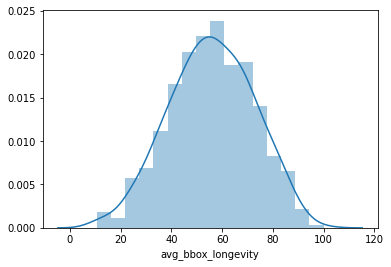

In [11]:
sns.distplot(df["avg_bbox_longevity"])

<AxesSubplot:xlabel='avg_num_bboxes'>

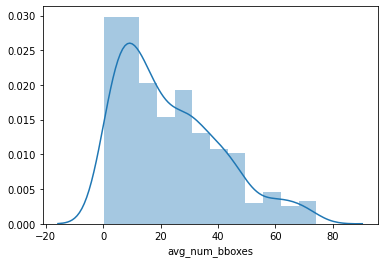

In [12]:
sns.distplot(df["avg_num_bboxes"])

Text(0.5, 0, 'Mean number of bounding boxes per scenario')

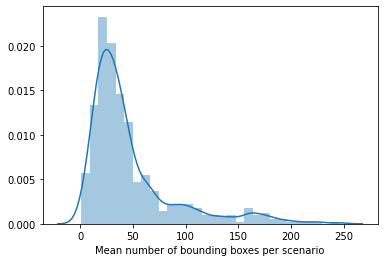

In [13]:
sns.distplot(df["avg_bbox_speed"])
plt.xlabel("Mean number of bounding boxes per scenario")

Text(0.5, 0, 'Mean bounding box speed per scenario')

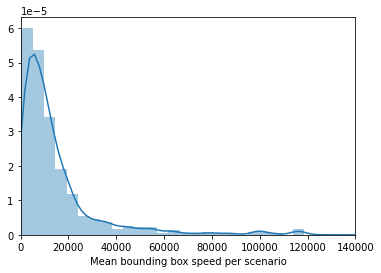

In [14]:
sns.distplot(df["avg_bbox_size"])
plt.xlim(0, 140000)
plt.xlabel("Mean bounding box speed per scenario")

Text(0.5, 0, 'Mean ego-vehicle speed [m/s]')

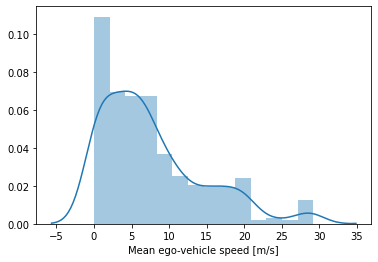

In [15]:
sns.distplot(df["avg_ego_speed"])
plt.xlabel("Mean ego-vehicle speed [m/s]")

<BarContainer object of 3 artists>

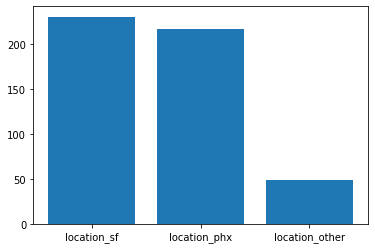

In [16]:
locations = dict(df["location"].value_counts())
plt.bar(locations.keys(), locations.values())

<BarContainer object of 3 artists>

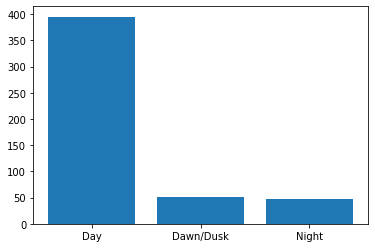

In [17]:
locations = dict(df["time_of_day"].value_counts())
plt.bar(locations.keys(), locations.values())

<BarContainer object of 2 artists>

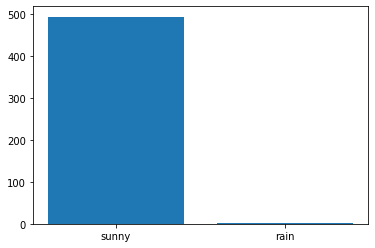

In [18]:
locations = dict(df["weather"].value_counts())
plt.bar(locations.keys(), locations.values())

In [18]:
for path in tqdm(list(Path("/data/ges/waymo/").glob("*/*.tfrecord"))):
    frames = frames_from_path(path)
    weathers = [frame.context.stats.weather for frame in frames]
    tods = [frame.context.stats.time_of_day for frame in frames]
    locs = [frame.context.stats.location for frame in frames]
    assert len(set(weathers)) == 1, path
    assert len(set(tods)) == 1, path
    assert len(set(locs)) == 1, path

100%|██████████| 273/273 [08:11<00:00,  1.80s/it]


In [59]:
df["scenario_name"][df["scenario_name"] == "training_0001-S15-P2_5"]

Series([], Name: scenario_name, dtype: object)

In [61]:
def featurize_2(frames_path, part_length_s):
    assert 20%part_length_s == 0, "20s (the time length of each scenario in waymo) is not divisible by {}".format(part_length_s)
    frames = frames_from_path(frames_path)
    result = []
    for i, frame_chunck in enumerate(chunks(frames, 10*part_length_s)):
        bbox_info = collect_bbox_info_per_frame(frame_chunck)
        vel = get_velocity(frame_chunck)
        ego_vehicle_speed = np.sqrt(vel[:, 0]**2 + vel[:, 1]**2 + vel[:, 2] ** 2)
        if np.max(bbox_info["num_bboxes"]) != 0:
            features = {
                "avg_bbox_longevity": np.mean(bbox_info["bbox_longevity"]),
                "90p_bbox_longevity": np.percentile(bbox_info["bbox_longevity"], 90),
                "90p_num_bboxes":  np.percentile(bbox_info["num_bboxes"], 90),
                "90p_bbox_speed":  np.percentile([np.mean(list(d.values())) if len(d.values()) > 0 else 0 for d in bbox_info["bbox_speed"]], 90),
                "90p_bbox_size":  np.percentile(bbox_info["avg_bbox_size"], 90),
                "avg_num_bboxes": np.mean(bbox_info["num_bboxes"]),
                "avg_bbox_speed": np.mean([np.mean(list(d.values())) if len(d.values()) > 0 else 0 for d in bbox_info["bbox_speed"]]),
                "avg_bbox_size": np.mean(bbox_info["avg_bbox_size"]),
                "avg_ego_speed": np.mean(ego_vehicle_speed),
                **get_context_info(frames)
            }
            result.append((i, features))
    return result

In [62]:
featurize_2("/data/ges/waymo/training_0001/S_15.tfrecord", 4)

[(0,
  {'avg_bbox_longevity': 19.363636363636363,
   '90p_bbox_longevity': 26.0,
   '90p_num_bboxes': 9.0,
   '90p_bbox_speed': 545.9948382097524,
   '90p_bbox_size': 153913.8374290439,
   'avg_num_bboxes': 5.325,
   'avg_bbox_speed': 345.05179530804907,
   'avg_bbox_size': 81222.84981927845,
   'avg_ego_speed': 2.5754862779300454,
   'time_of_day': 'Day',
   'weather': 'sunny',
   'location': 'location_sf'}),
 (1,
  {'avg_bbox_longevity': 39.0,
   '90p_bbox_longevity': 39.0,
   '90p_num_bboxes': 1.0,
   '90p_bbox_speed': 253.3146394070995,
   '90p_bbox_size': 163607.7959286404,
   'avg_num_bboxes': 0.975,
   'avg_bbox_speed': 133.95163294694265,
   'avg_bbox_size': 130512.41797793047,
   'avg_ego_speed': 0.6680267822172526,
   'time_of_day': 'Day',
   'weather': 'sunny',
   'location': 'location_sf'}),
 (3,
  {'avg_bbox_longevity': 18.272727272727273,
   '90p_bbox_longevity': 22.0,
   '90p_num_bboxes': 10.0,
   '90p_bbox_speed': 604.8242910077233,
   '90p_bbox_size': 99568.82442956671